In [1]:
import os
import json
from glob import glob
import torch
from my_lib import ROOT
import my_lib
import scipy
from torch_geometric.data import Data
from scipy.stats import wasserstein_distance
import numpy as np
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa
import ot

In [2]:
data_dir=os.path.join(ROOT,'data','raw','test')
# with open(data_dir) as f:
#     data = json.load(f)
data={}
files=glob(data_dir + '/*.json')
for file in files:
    print(file)
    filename=file.split(os.sep)[-1].split('.')[0]
    with open(file,'r') as f:
        tmp = json.load(f)

    data.update({filename:tmp})

print(data.keys())


C:\Users\lllang\Desktop\side_projects\pyg\data\raw\test\cube-like_1.json
C:\Users\lllang\Desktop\side_projects\pyg\data\raw\test\cube-like_2.json
C:\Users\lllang\Desktop\side_projects\pyg\data\raw\test\cube.json
C:\Users\lllang\Desktop\side_projects\pyg\data\raw\test\dod-like.json
C:\Users\lllang\Desktop\side_projects\pyg\data\raw\test\dod.json
C:\Users\lllang\Desktop\side_projects\pyg\data\raw\test\oct-like.json
C:\Users\lllang\Desktop\side_projects\pyg\data\raw\test\oct.json
C:\Users\lllang\Desktop\side_projects\pyg\data\raw\test\rotated_tetra.json
C:\Users\lllang\Desktop\side_projects\pyg\data\raw\test\scaled_tetra.json
C:\Users\lllang\Desktop\side_projects\pyg\data\raw\test\tetra-like.json
C:\Users\lllang\Desktop\side_projects\pyg\data\raw\test\tetra.json
dict_keys(['cube-like_1', 'cube-like_2', 'cube', 'dod-like', 'dod', 'oct-like', 'oct', 'rotated_tetra', 'scaled_tetra', 'tetra-like', 'tetra'])


In [3]:
# Define a cube
cube_vertices = torch.tensor(data['cube']['vertices'], dtype=torch.float)

cube_edges = torch.tensor([
    [0, 1], [0, 2], [0, 4], [1, 3], [1, 5], [2, 3], [2, 6], 
    [3, 7], [4, 5], [4, 6], [5, 7], [6, 7]
], dtype=torch.long).t().contiguous()

cube = Data(x=cube_vertices, edge_index=cube_edges)

# Define a tetrahedron
tetrahedron_vertices = torch.tensor(data['tetra']['vertices'], dtype=torch.float)

tetrahedron_edges = torch.tensor([
    [0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]
], dtype=torch.long).t().contiguous()

tetrahedron = Data(x=tetrahedron_vertices, edge_index=tetrahedron_edges)
# Calculate EMD
emd = wasserstein_distance(cube.x.view(-1), tetrahedron.x.view(-1))

print(f"Earth Mover's Distance: {emd}")

Earth Mover's Distance: 0.36623583237330115


In [4]:
# Calculate EMD
emd = wasserstein_distance(tetrahedron.x.view(-1), tetrahedron.x.view(-1))

print(f"Earth Mover's Distance: {emd}")

Earth Mover's Distance: 0.0


In [19]:
import numpy as np
from gudhi.wasserstein import wasserstein_distance

dgm1 = np.array(data['cube']['vertices'])
dgm2 = np.array(data['tetra']['vertices'])
rotated_dgm1=my_lib.math.rot_z(dgm1,45)

In [20]:
cost, matchings = wasserstein_distance(dgm1, dgm2, matching=True, order=1, internal_p=2)
print(f"Wasserstein distance value = {cost:.2f}")

cost, matchings = wasserstein_distance(dgm1, rotated_dgm1, matching=True, order=1, internal_p=2)
print(f"Wasserstein distance value = {cost:.2f}")


cost, matchings = wasserstein_distance(dgm1, dgm1, matching=True, order=1, internal_p=2)
print(f"Wasserstein distance value = {cost:.2f}")


print("\nSecond example:")
print(f"cost: {cost}")
print(f"matchings: {matchings}")

Wasserstein distance value = -1.31
Wasserstein distance value = -1.33
Wasserstein distance value = -2.83

Second example:
cost: -2.8284271247461903
matchings: [[ 0 -1]
 [ 1  1]
 [ 2  2]
 [ 3  3]
 [ 4 -1]
 [ 5 -1]
 [ 6 -1]
 [ 7  7]
 [-1  0]
 [-1  4]
 [-1  5]
 [-1  6]]


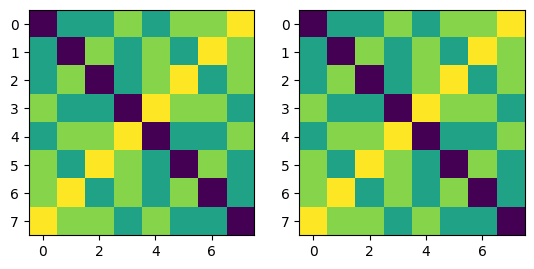

In [7]:
C1 = scipy.spatial.distance.cdist(dgm1, dgm1)
C2 = scipy.spatial.distance.cdist(rotated_dgm1, rotated_dgm1)

C1 /= C1.max()
C2 /= C2.max()

pl.figure()
pl.subplot(121)
pl.imshow(C1)
pl.subplot(122)
pl.imshow(C2)
pl.show()

It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.609887e-01|0.000000e+00|0.000000e+00
    1|4.083603e-02|2.942320e+00|1.201526e-01
    2|4.083603e-02|0.000000e+00|0.000000e+00
It.  |Err         
-------------------
    0|1.740309e-14|
Gromov-Wasserstein distances: 0.04083602707514607
Entropic Gromov-Wasserstein distances: 0.16098867265804112


Text(0.5, 1.0, 'Entropic Gromov Wasserstein')

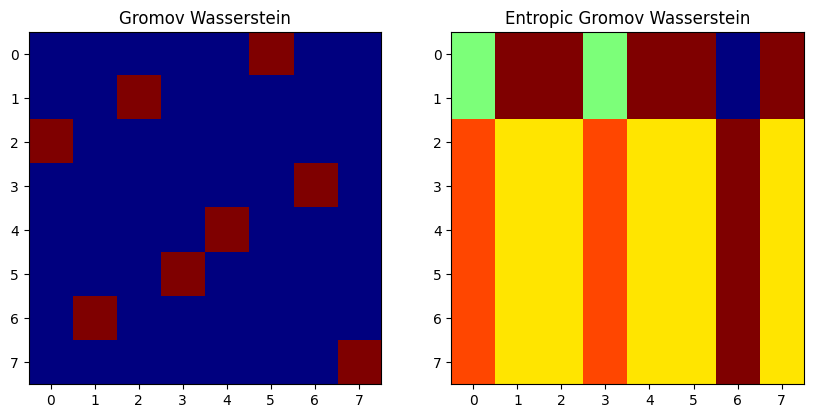

In [8]:
n_p=dgm1.shape[0]
n_q=rotated_dgm1.shape[0]



p = ot.unif(n_p)
q = ot.unif(n_q)
gw0, log0 = ot.gromov.gromov_wasserstein(
    C1, C2, p, q, 'square_loss', verbose=True, log=True)

gw, log = ot.gromov.entropic_gromov_wasserstein(
    C1, C2, p, q, 'square_loss', epsilon=5e-4, log=True, verbose=True)


print('Gromov-Wasserstein distances: ' + str(log0['gw_dist']))
print('Entropic Gromov-Wasserstein distances: ' + str(log['gw_dist']))

pl.figure(1, (10, 5))

pl.subplot(1, 2, 1)
pl.imshow(gw0, cmap='jet')
pl.title('Gromov Wasserstein')

pl.subplot(1, 2, 2)
pl.imshow(gw, cmap='jet')
pl.title('Entropic Gromov Wasserstein')



Pointwise Gromov-Wasserstein distance estimated: 8.326672684688674e-17
Variance estimated: 0.0


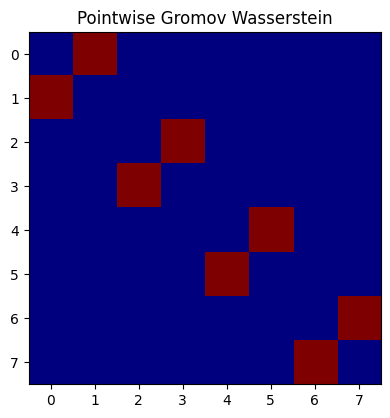

{'gw_dist_estimated': 8.326672684688674e-17, 'gw_dist_std': 0.0}


In [9]:
def loss(x, y):
    return np.abs(x - y)


pgw, plog = ot.gromov.pointwise_gromov_wasserstein(C1, C2, p, q, loss, max_iter=100,
                                                   log=True)

# sgw, slog = ot.gromov.sampled_gromov_wasserstein(C1, C2, p, q, loss, epsilon=0.1, max_iter=100,
#                                                  log=True)

print('Pointwise Gromov-Wasserstein distance estimated: ' + str(plog['gw_dist_estimated']))
print('Variance estimated: ' + str(plog['gw_dist_std']))
# print('Sampled Gromov-Wasserstein distance: ' + str(slog['gw_dist_estimated']))
# print('Variance estimated: ' + str(slog['gw_dist_std']))


pl.figure(1, (10, 5))

pl.subplot(1, 2, 1)
pl.imshow(pgw.toarray(), cmap='jet')
pl.title('Pointwise Gromov Wasserstein')

# pl.subplot(1, 2, 2)
# pl.imshow(sgw, cmap='jet')
# pl.title('Sampled Gromov Wasserstein')

pl.show()
print(plog)

Sampled Gromov-Wasserstein distance: 0.15070329483540026
Variance estimated: 0.01854087445100547
{'gw_dist_estimated': 0.15070329483540026, 'gw_dist_std': 0.01854087445100547}


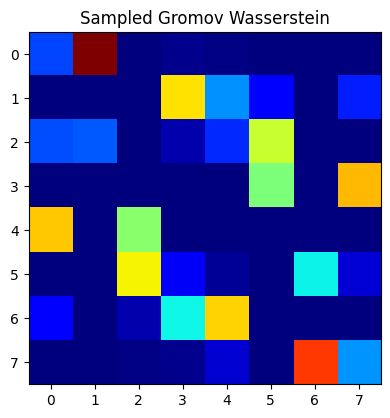

In [10]:
sgw, slog = ot.gromov.sampled_gromov_wasserstein(C1, C2, p, q, loss, epsilon=0.2,nb_samples_grad=50, max_iter=100,
                                                 log=True)
print('Sampled Gromov-Wasserstein distance: ' + str(slog['gw_dist_estimated']))
print('Variance estimated: ' + str(slog['gw_dist_std']))
pl.figure(1, (10, 5))

pl.subplot(1, 2, 2)
pl.imshow(sgw, cmap='jet')
pl.title('Sampled Gromov Wasserstein')

print(slog)

In [11]:
def similarity_score(point_set_1, point_set_2, loss=None,max_iter=100,alpha=1,threshold_plan =0):
    if loss is None:
        def loss(x, y):
            return np.abs(x - y)

    # https://pythonot.github.io/gen_modules/ot.gromov.html
    C1 = scipy.spatial.distance.cdist(point_set_1, point_set_1)
    C2 = scipy.spatial.distance.cdist(point_set_2, point_set_2)

    C1 /= C1.max()
    C2 /= C2.max()

    n_p=point_set_1.shape[0]
    n_q=point_set_2.shape[0]
    p = ot.unif(n_p)
    q = ot.unif(n_q)
    pgw, plog = ot.gromov.pointwise_gromov_wasserstein(C1, C2, p, q, loss, 
                                                       max_iter=max_iter,
                                                       alpha=alpha,
                                                       threshold_plan=threshold_plan,
                                                        log=True)
    
    return plog['gw_dist_estimated'],plog['gw_dist_std']


In [12]:
shape_names=list(data.keys())
for i,name in enumerate(shape_names):
    print(name,i)
print(shape_names)
custom_names_index=[0,1,3,5,9,7,8,10,2,6,4]
shape_names_custom=[shape_names[i] for i in custom_names_index  ]
n_shapes=len(shape_names_custom)


similarity_matrix=np.zeros(shape=(n_shapes,n_shapes))
similarity_matrix_std=np.zeros(shape=(n_shapes,n_shapes))
for i,shape_name_i in enumerate(shape_names_custom):
    for j,shape_name_j in enumerate(shape_names_custom):
        point_set_1=np.array(data[shape_name_i]['vertices'])
        point_set_2=np.array(data[shape_name_j]['vertices'])
        similarity,similarity_std=similarity_score(point_set_1, point_set_2,max_iter=100)
        similarity_matrix[i,j]=similarity
        similarity_matrix_std[i,j]=similarity_std

cube-like_1 0
cube-like_2 1
cube 2
dod-like 3
dod 4
oct-like 5
oct 6
rotated_tetra 7
scaled_tetra 8
tetra-like 9
tetra 10
['cube-like_1', 'cube-like_2', 'cube', 'dod-like', 'dod', 'oct-like', 'oct', 'rotated_tetra', 'scaled_tetra', 'tetra-like', 'tetra']


In [13]:
def plot_similarity_matrix( similarity_matrix, labels, add_values=True, filename=None):
    fig, ax = plt.subplots()
    cax = ax.matshow(similarity_matrix, cmap='coolwarm')  # Change the color map here
    fig.colorbar(cax)

    plt.xticks(range(len(labels)), labels, rotation=90)
    plt.yticks(range(len(labels)), labels)

    fig.suptitle('Similarity matrix')

    if add_values:
        for i in range(similarity_matrix.shape[0]):
            for j in range(similarity_matrix.shape[1]):
                ax.text(j, i, format(similarity_matrix[i, j], ".2f"), 
                        ha="center", va="center", 
                        color="w" if np.abs(similarity_matrix[i, j]) > 0.5 else "black")
    
    plt.tight_layout()
    if filename:
        plt.savefig(filename)
    else:
        plt.show()


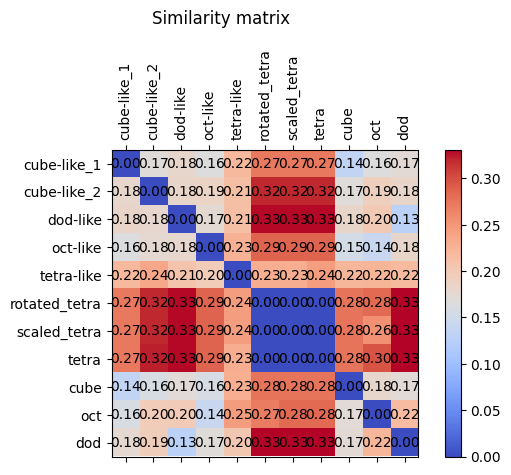

In [14]:
plot_similarity_matrix( similarity_matrix, labels=shape_names_custom)

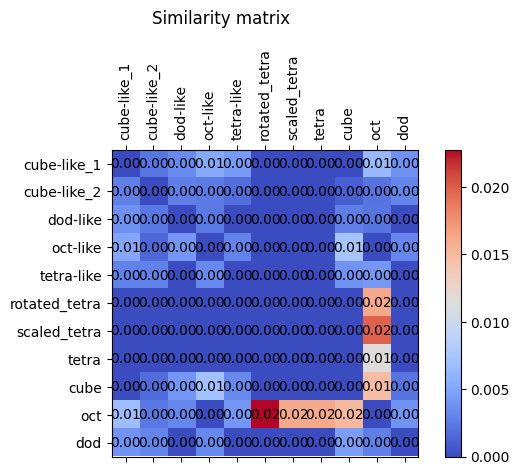

In [15]:
plot_similarity_matrix( similarity_matrix_std, labels=shape_names_custom)

In [16]:
def loss_MSLE(x, y):
    return (np.log1p(x) - np.log1p(y)) ** 2
def loss_MAE(x, y):
    return np.abs(x - y)
def loss_MSE(x, y):
    return (x-y) ** 2
def loss_Huber(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = np.abs(error) < delta
    squared_loss = 0.5 * (error**2)
    linear_loss = delta * (np.abs(error) - 0.5 * delta)
    return np.where(is_small_error, squared_loss, linear_loss)


shape_names=list(data.keys())
for i,name in enumerate(shape_names):
    print(name,i)
print(shape_names)
custom_names_index=[0,1,3,5,9,7,8,10,2,6,4]
shape_names_custom=[shape_names[i] for i in custom_names_index  ]
n_shapes=len(shape_names_custom)


similarity_matrix=np.zeros(shape=(n_shapes,n_shapes))
similarity_matrix_std=np.zeros(shape=(n_shapes,n_shapes))
for i,shape_name_i in enumerate(shape_names_custom):
    for j,shape_name_j in enumerate(shape_names_custom):
        point_set_1=np.array(data[shape_name_i]['vertices'])
        point_set_2=np.array(data[shape_name_j]['vertices'])
        similarity,similarity_std=similarity_score(point_set_1, point_set_2,loss=loss_MAE,max_iter=50,alpha=1,threshold_plan =0)
        similarity_matrix[i,j]=similarity
        similarity_matrix_std[i,j]=similarity_std

cube-like_1 0
cube-like_2 1
cube 2
dod-like 3
dod 4
oct-like 5
oct 6
rotated_tetra 7
scaled_tetra 8
tetra-like 9
tetra 10
['cube-like_1', 'cube-like_2', 'cube', 'dod-like', 'dod', 'oct-like', 'oct', 'rotated_tetra', 'scaled_tetra', 'tetra-like', 'tetra']


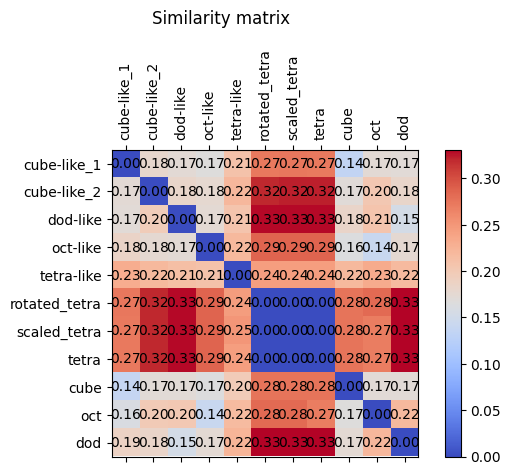

In [17]:
plot_similarity_matrix( similarity_matrix, labels=shape_names_custom)